In [1]:
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim

import torchvision
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as vutils
from torch.utils.data import Dataset

from torchsummary import summary
import ignite
from ignite.engine import Engine,Events
import ignite.distributed as idist

import logging
import wandb
import time
import os
from natsort import natsorted
import PIL
import imageio as iio
import math
import random

import matplotlib.pyplot as plt
import numpy as np

if torch.cuda.is_available():
    import torch.backends.cudnn as cudnn
    cudnn.benchmark = True
    
from IPython.display import Image
to_img = transforms.ToPILImage()

In [2]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--image_size', type=int, default=128)
parser.add_argument('--batch_size', type=int, default=64) # DCGAN paper original value used 128
parser.add_argument('--n_colors', type=int, default=3)
parser.add_argument('--z_size', type=int, default=100) # DCGAN paper original value
parser.add_argument('--G_h_size', type=int, default=128, help='Number of hidden nodes in the Generator. Too small leads to bad results, too big blows up the GPU RAM.') # DCGAN paper original value
parser.add_argument('--D_h_size', type=int, default=128, help='Number of hidden nodes in the Discriminator. Too small leads to bad results, too big blows up the GPU RAM.') # DCGAN paper original value
parser.add_argument('--lr_D', type=float, default=.00005, help='Discriminator learning rate') # 1/4 of DCGAN paper original value
parser.add_argument('--lr_G', type=float, default=.0002, help='Generator learning rate') # DCGAN paper original value
parser.add_argument('--n_epoch', type=int, default=1000)
parser.add_argument('--beta1', type=float, default=0.5, help='Adam betas[0], DCGAN paper recommends .50 instead of the usual .90')
parser.add_argument('--SELU', type=bool, default=False, help='Using scaled exponential linear units (SELU) which are self-normalizing instead of ReLU with BatchNorm. This improves stability.')
parser.add_argument('--seed', type=int)
parser.add_argument('--input_folder', default='./cats_bigger_than_64x64/', help='input folder')
parser.add_argument('--output_folder', default='Output/DCGAN', help='output folder')
parser.add_argument('--G_load', default='', help='Full path to Generator model to load (ex: /home/output_folder/run-5/models/G_epoch_11.pth)')
parser.add_argument('--D_load', default='', help='Full path to Discriminator model to load (ex: /home/output_folder/run-5/models/D_epoch_11.pth)')
parser.add_argument('--cuda', type=bool, default=torch.cuda.is_available(), help='enables cuda')
parser.add_argument('--n_gpu', type=int, default=torch.cuda.device_count(), help='number of GPUs to use')
parser.add_argument('--n_workers', type=int, default=2, help='Number of subprocess to use to load the data. Use at least 2 or the number of cpu cores - 1.')
parser.add_argument('--weight_decay', type=float, default=0, help='L2 regularization weight. Greatly helps convergence but leads to artifacts in images, not recommended.')
parser.add_argument('--gen_extra_images', type=int, default=0, help='Every epoch, generate additional images with "batch_size" random fake cats.')

args, unknown = parser.parse_known_args()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(*map(lambda m:": ".join((m.__name__,m.__version__)),(torch,torchvision,ignite)),sep="\n")

torch: 1.12.0+cu102
torchvision: 0.13.0+cu102
ignite: 0.4.9


In [4]:
# wandb.finish()
# !pip install pytorch-ignite

In [5]:
# !pip install cv2
# !pip install opencv-python

In [6]:
# !pip install wandb -qqq


In [7]:
wandb.login()

wandb: Currently logged in as: londanizuma (londaniteam). Use `wandb login --relogin` to force relogin


True

In [8]:
# !wandb login --relogin
wb_run = wandb.init(settings=wandb.Settings(start_method="fork"),project="cat-generation-DCGAN",config={"architecture": "DCGA"})
wandb.config.update(args) # adds all of the arguments as config variables
param = wandb.config

print(param)


{'architecture': 'DCGA', 'image_size': 128, 'batch_size': 64, 'n_colors': 3, 'z_size': 100, 'G_h_size': 128, 'D_h_size': 128, 'lr_D': 5e-05, 'lr_G': 0.0002, 'n_epoch': 1000, 'beta1': 0.5, 'SELU': False, 'seed': None, 'input_folder': './cats_bigger_than_64x64/', 'output_folder': 'Output/DCGAN', 'G_load': '', 'D_load': '', 'cuda': True, 'n_gpu': 1, 'n_workers': 2, 'weight_decay': 0, 'gen_extra_images': 0}


In [9]:

start = time.time()

run=0
base_dir = f"{param.output_folder}/run-{run}/"
while os.path.exists(base_dir):
    run+=1
    base_dir = f"{param.output_folder}/run-{run}"
os.makedirs(base_dir)
os.makedirs(f"{base_dir}/models")

In [10]:
param.seed = param.seed or random.randint(1,10000)
print(f"Random Seed: {param.seed}")
wandb.log({"Random": param.seed})
random.seed(param.seed)
torch.manual_seed(param.seed)
ignite.utils.manual_seed(param.seed)

if param.cuda:
    torch.cuda.manual_seed_all(param.seed)
    
ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader",level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel",level=logging.WARNING)

## Transforming images
trans = transforms.Compose([
    transforms.Resize((param.image_size,param.image_size)),
    # This makes it into [0,1]
    transforms.ToTensor(),
    # This makes it into [-1,1] so tanh will work properply
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = PIL.Image.open(img_loc).convert("RGB")
        # image = iio.imread(img_loc)
        tensor_image = self.transform(image)
        return tensor_image
    
train_dataset = CustomDataSet(param.input_folder, transform=trans)
test_dataset = torch.utils.data.Subset(train_dataset,torch.arange(9000))


Random Seed: 5289


We wish to configure the dataloader to work in a disbtributed environment. Distributed Dataloading is support by Ignite as part of DDP support. This requires specific adjustments to the sequential case.

To handle this, `idist` provides an helper [`auto_dataloader`](https://pytorch.org/ignite/v0.4.5/generated/ignite.distributed.auto.auto_dataloader.html#auto-dataloader) which automatically distributes the data over the processes.

**Note**: Distributed dataloading is described in [Distributed Data Parallel (DDP)](https://pytorch.org/tutorials/intermediate/ddp_tutorial.html) tutorial if you wish to learn more.

In [11]:
train_dataloader = idist.auto_dataloader(
    train_dataset,
    batch_size=param.batch_size,
    num_workers=param.n_workers,
    shuffle=True,
    drop_last=True,
)

test_dataloader = idist.auto_dataloader(
    test_dataset,
    batch_size=param.batch_size,
    num_workers=param.n_workers,
    shuffle=False,
    drop_last=True,
)

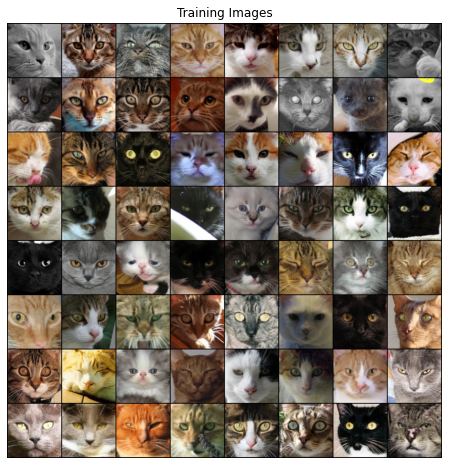

In [12]:
real_batch = next(iter(train_dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[:64],padding=2,normalize=True).cpu(),(1,2,0)))
plt.show()

In [13]:
## Models
# The number of layers is implicitly determined by the image size
# image_size = (4,8,16,32,64,128,256, 512, 1024) leads to n_layers = (1,2,3,4,5,6,7,8,9)

# The more layers the bigger the neural get so it's best to decrease D_h_size and D_h_size when the image input is bigger

# DCGAN generator
class DCGAN_G(torch.nn.Module):
    def __init__(self):
        super(DCGAN_G,self).__init__()
        main = torch.nn.Sequential()
        
        # We need to know how many layers we will use at the beginning
        mult = param.image_size // 8
        
        
        ### Start block
        # Z_size random numbers
        main.add_module('Start-ConvTranspose2d',torch.nn.ConvTranspose2d(param.z_size,param.G_h_size*mult,kernel_size=4,stride=1,padding=0,bias=False))
        if param.SELU:
            main.add_module('Start-SELU',torch.nn.SELU(inplace=True))
        else:
            main.add_module('Start-BatchNorm2d',torch.nn.BatchNorm2d(param.G_h_size*mult))
            main.add_module('Start-ReLU',torch.nn.ReLU())
        # Size = (G_h_size * mult)x 4 x4
        
        ### Middle block (Done until we reach  ? x image_size/2 x image_size/2)
        i=1
        while mult>1:
            main.add_module('Middle-ConvTranspose2d [%d]'%i, torch.nn.ConvTranspose2d(param.G_h_size*mult,param.G_h_size*(mult//2),kernel_size=4,stride=2,padding=1,bias=False))
            if param.SELU:
                main.add_module('Middle-SELU [%d]'%i,torch.nn.SELU(inplace=True))
            else:
                main.add_module('Middle-BatchNorm2d [%d]'%i,torch.nn.BatchNorm2d(param.G_h_size*(mult//2)))
                # main.add_module('Middle_ReLU [$d]'%i,torch.nn.SELU(inplace=True))
                main.add_module('Middle-ReLU [%d]' % i, torch.nn.ReLU(inplace=True))
            # Size = (G_h_size * (mult/(2*i)))x8x8
            mult = mult // 2
            i+=1
        
        ### End block
        # Size = G_h_size/2 x image_size/2
        main.add_module('End-ConvTransposed2d', torch.nn.ConvTranspose2d(param.G_h_size,param.n_colors,kernel_size=4,stride=2,padding=1,bias=False))
        main.add_module('End-Tanh',torch.nn.Tanh())
        # Size = n_colors x image_size x image_size
        self.main = main
    
    def forward(self,input):
        if isinstance(input.data,torch.cuda.FloatTensor) and param.n_gpu>1:
            output = torch.nn.parallel.data_parallel(self.main,input,range(param.n_gpu))
        else:
            output = self.main(input)
        return output
# DCGAN discriminator ( using somewhat the reverse of the generator)
class DCGAN_D(torch.nn.Module):
    def __init__(self):
        super(DCGAN_D,self).__init__()
        main = torch.nn.Sequential()
        
        ### start block
        # size = n_colors x image_size x image_size
        main.add_module('Start-conv2d',torch.nn.Conv2d(param.n_colors,param.D_h_size,kernel_size=4,stride=2,padding=1,bias=False))
        if param.SELU:
            main.add_module('Start-SELU',torch.nn.SELU(inplace=True))
        else:
            main.add_module('Start-LeakyReLU',torch.nn.LeakyReLU(0.2,inplace=True))
        image_size_new = param.image_size // 2
        # Size = D_h_size x image_size/2 x image_size/2
        
        ### Middle block (Done until we reach ? x 4 x4)
        mult = 1
        i=0
        while image_size_new>4:
            main.add_module('Middle-Conv2d [%d]'%i,torch.nn.Conv2d(param.D_h_size*mult,param.D_h_size*(2*mult),kernel_size=4,stride=2,padding=1,bias=False))
            if param.SELU:
                main.add_module('Middle-SELU [%d]'%i,torch.nn.SELU(inplace=True))
            else:
                main.add_module('Middle-BatchNorm2d [%d]'%i,torch.nn.BatchNorm2d(param.D_h_size*(2*mult)))
                main.add_module('Middle-LeakyReLU [%d]'%i,torch.nn.LeakyReLU(0.2,inplace=True))
            # Size = (D_h_size*(2*i)) x image_size/(2*i) x image_size/(2*i)
            image_size_new = image_size_new // 2
            mult *=2
            i +=1
            
        ## End Block
        # size = (D_h_size*mult) x 4 x4
        main.add_module('End-Conv2d',torch.nn.Conv2d(param.D_h_size*mult,1,kernel_size=4,stride=1,padding=0,bias=False))
        main.add_module('Sigmoid',torch.nn.Sigmoid())
        # size = 1 x1 x1 (Is a real cat or not)
        self.main = main
    def forward(self,input):
        if isinstance(input.data,torch.cuda.FloatTensor) and param.n_gpu>1:
            output = torch.nn.parallel.data_parallel(self.main,input,range(param.n_gpu))
        else:
            output = self.main(input)
            
            # Convert from 1 x 1 x 1 to 1 so that we can compare to given label (cat or not?)
        return output.view(-1)
        
## weights init function, DCGAN use 0.02 std
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0,0.02)
    elif classname.find('BatchNorm') != -1:
        # estimate variance, must be around 1
        m.weight.data.normal_(1.0,0.02)
        # estimate mean, must be around 0
        m.bias.data.fill_(0)
        
G = idist.auto_model(DCGAN_G())
D = idist.auto_model(DCGAN_D())

if param.G_load !='':
    G.load_state_dict(torch.load(param.G_load))
if param.D_load !='':
    D.load_state_dict(torch.load(param.D_load))
    
print(G)
print(D)

criterion = torch.nn.BCELoss()

z_test = torch.randn(param.batch_size, param.z_size, 1, 1, device=idist.device())

optimizerD = idist.auto_optim(
    optim.Adam(D.parameters(),lr=param.lr_D,betas=(param.beta1,0.999),weight_decay=param.weight_decay
))

optimizerG = idist.auto_optim(
    optim.Adam(G.parameters(),lr=param.lr_G,betas=(param.beta1,0.999),weight_decay=param.weight_decay)
)


DCGAN_G(
  (main): Sequential(
    (Start-ConvTranspose2d): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (Start-BatchNorm2d): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Start-ReLU): ReLU()
    (Middle-ConvTranspose2d [1]): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (Middle-BatchNorm2d [1]): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Middle-ReLU [1]): ReLU(inplace=True)
    (Middle-ConvTranspose2d [2]): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (Middle-BatchNorm2d [2]): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Middle-ReLU [2]): ReLU(inplace=True)
    (Middle-ConvTranspose2d [3]): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (Middle-BatchNorm2d [3]): BatchNorm2d(256, eps=1e-0

## Ignite Training Concepts

Training in Ignite is based on three core components, namely, Engine, Events and Handlers. Let's briefly discuss each of them.

*   **Engine** - The [Engine](https://pytorch.org/ignite/generated/ignite.engine.engine.Engine.html#engine) can be considered somewhat similar to a training loop. It takes a `train_step` as an argument and runs it  over each batch of the dataset, triggering events as it goes.

*   **Events** - [Events](https://pytorch.org/ignite/generated/ignite.engine.events.Events.html#events) are emitted by the Engine when it reaches a specific point in the run/training.

*   **Handlers** - Functions that can be triggered when a certain Event is emitted by the Engine. Ignite has a long list of pre defined Handlers such as checkpoint, early stopping, logging and built-in metrics, see [ignite-handlers](https://pytorch.org/ignite/handlers.html#ignite-handlers).

### Training Step Function

A training step function will be run batch wise over the entire dataset by the engine. It contains the basic training steps, namely, running the model, propagating the loss backward and taking an optimizer step. We run the discriminator model on both real images and fake images generated by the Generator model. The function returns Generator and Discriminator Losses and the output generated by Generator and Discriminator.

In [14]:
def log_images(images):
    img_grid = torchvision.utils.make_grid(images)
    img = wandb.Image(img_grid)
    wandb.log({"examples": img})
    
    fake_test = G(z_test)
    log_images(fake_test)

In [15]:
def training_step(engine,data):
    # Set the models for training
    G.train()
    D.train()
    
    # Updatee D network: maximize log(D(x)) + log(1-D(G(z)))
    
    # Train with real data
    D.zero_grad()
    # We can ignore labels since they are all cats
    images = data.to(idist.device())
    # Mostly necessary for the last one because if the N might not be a multiple of batch_size
    current_batch_size = images.size(0)

    # Transfer batch of images to x
    # y is now a vector of size current_batch_size filled with 1
    y = torch.ones(current_batch_size).to(idist.device())
    y_pred = D(images)
    errD_real = criterion(y_pred,y)
    errD_real.backward()
    # Var has data and gradient element, we keep the mean of the data element
    D_real = torch.mean(y_pred).item()
        
    # Train with fake data
    z = torch.randn(current_batch_size,param.z_size,1,1).to(idist.device())
    x_fake = G(z)
    y = torch.zeros(current_batch_size).to(idist.device())
    
    # Detach y_pred from the neural network G and put it inside D
    y_pred_fake = D(x_fake.detach())
    errD_fake = criterion(y_pred_fake,y)
    errD_fake.backward()
    D_fake = torch.mean(y_pred_fake).item()
    errD = errD_real + errD_fake
    optimizerD.step()
        
    # Update G net work

    G.zero_grad()
    # Generator wants to foll discriminaor so it wants to minimize loss of discriminator assuming label is True
    y = torch.ones(current_batch_size).to(idist.device())
    y_pred_fake = D(x_fake)
    errG = criterion(y_pred_fake,y)
    errG.backward()
    D_G = torch.mean(y_pred_fake).item()
    optimizerG.step()

    # Log results so we can see them in TensorBoard after
    return {"Loss_G": errG.item(),
           "Loss_D": errD.item(),
           "D_x":D_real,
           "D_G_z1":D_fake,
           "D_G_z2":D_G,}


A `PyTorch-Ignite` engine `trainer` is defined using the above `training_step` function.

In [16]:
trainer = Engine(training_step)

### Handlers
In this section, the used `PyTorch-Ignite` handlers are introduced. These handlers will be responsible for printing out and storing important information such as losses and model predictions.

Like the DCGAN paper, we will also randomly initialize all the model weights from a Normal Distribution with `mean=0`, `stdev=0.02`. The following `initialize_fn` function must be applied to the generator and discriminator models at the start of training.

In [17]:
@trainer.on(Events.STARTED)
def init_weights():
    D.apply(weights_init)
    G.apply(weights_init)

The `store_losses` handler is responsible for storing the generator and discriminator losses in `G_losses` and `D_losses` respectively. It is triggered at the end of every iteration.

In [18]:
G_losses = []
D_losses = []

@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])
    metrics = {"train/errD": o["Loss_D"], 
           "train/errG": o["Loss_G"]}
    wandb.log(metrics)

The `store_images` handler is responsible for storing the images generated by the generator model during training. It provides us with a visual progress of the training. It is triggered every `500` iterations.

In [19]:
img_list=[]

@trainer.on(Events.ITERATION_COMPLETED(every=500))
def store_images(engine):
    with torch.no_grad():
        fake = G(z_test).cpu()
    img_list.append(fake)
    log_images(fake)   

## Evaluation Metrics

For this tutorial, we will be showcasing two GAN based metric, namely, Frechet Inception Distance (FID) and Inception Score (IS). 

Inception Score (IS) is an objective metric for evaluating the quality of generated images, specifically synthetic images output by generative adversarial network models. It uses the classification probabilities provided by a pre-trained Inceptionv3 Model to measure performance of a GAN. You can find more Inception Score in the paper found [here](https://arxiv.org/pdf/1801.01973.pdf).

Frechet Inception Distance (FID) is a metric that calculates the distance between feature vectors calculated for real and generated images. Like IS, it also uses a pre-trained Inceptionv3 model. It uses the mean and covariance between the real and generated images' feature vectors to measure performance of a GAN. You can find more about Frechet Inception Distance in the paper found [here](https://arxiv.org/pdf/1706.08500.pdf)


These metric are provided by the [`ignite.metric`](https://pytorch.org/ignite/v0.4.5/metrics.html) submodule which provides a way to compute various quantities of interest in an online fashion without having to store the entire output history of a model. 

In this example, the `FID` and `IS` metrics are computed every epoch, therefore an specific handler `log_training_results` should be triggered every epoch. Since the metric run on the entire dataset a separate engine `train_evaluator` is defined which will be run by `log_training_results` handler. 

In [20]:
from ignite.metrics import FID, InceptionScore

The `FID` and `InceptionScore` metrics are created as the following. Here we wish to use `gpu` so we set the device to `idist.device()` but the metrics will be on `cpu` device by default if no metric is passed.

In [21]:
fid_metric = FID(device=idist.device())

/home-mscluster/lzuma/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home-mscluster/lzuma/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
is_metric = InceptionScore(device=idist.device(),output_transform=lambda x:x[0])

## Evaluators

We define the function for the evaluation engine, namely, `evaluation_step`. Our dataset provides `64 x 64 x 3` images but both `IS` and `FID` metrics use the `Inceptionv3` model for evaluation which requires images of minimum size `299 x 299 x 3`, so the images from the dataset and the images generated by the generator model must be interpolated.

Although pytorch has a native interpolate function, `PIL` interpolation is used instead because of poor anitaliasing in torch which can lead to poor scaling of images. These inconsistencies among implementations can have a drastic effect on the evaluations metrics and their final results. [Parmar et al. (2021)](https://arxiv.org/abs/2104.11222) explains in much greater detail about the differences and inconsistencies in the interpolation functions of various libraries.

In [23]:
def interpolate(batch):
    arr=[]
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img= pil_img.resize((299,299),PIL.Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

def evaluation_step(engine,batch):
    with torch.no_grad():
        noise = torch.randn(param.batch_size,param.z_size,1,1,device=idist.device())
        G.eval()
        fake_batch = G(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch)
        return fake,real

The `train_evaluator` engine will run the metric on the entire dataset every epoch and attach `IS` and `FID` metrics to it.

In [24]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator,"fid")
is_metric.attach(evaluator,"is")

The following handler attached to the `trainer` engine triggered every epoch will run the `train_evaluator` engine to evaluate the `IS` and `FID` metrics. The results are finally stored per epoch.

In [25]:
fid_values =[]
is_values = []

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    
    metrics = {"FID": fid_score, 
       "IS": is_score}
    wandb.log(metrics)


@trainer.on(Events.EPOCH_COMPLETED(every=500))
def save_model(engine):
    torch.save(G.state_dict(),fmt%(param.output_folder, run, 'G',engine.state.epoch))
    torch.save(D.state_dict(), fmt%(param.output_folder, run,'D',engine.state.epoch))
    fmt = '%s/run-%d/models/'
    trained_model = wandb.Artifact("DCGAN_model_epoch_{}".format(engine.state.epoch),type="model")
    trained_model.add_dir(fmt%(param.output_folder, run))
    wb_run.log_artifact(trained_model)

## Loss metrics

The `RunningAverage` metric is used to keep track of the generator and discriminator Losses. Like the name suggests, `RunningAverage` keeps the track of average of all the values provided to it.

In [26]:
from ignite.metrics import RunningAverage

RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer,'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer,'Loss_D')

## Progress bars

Since the training process can take a lot of time and have a lot of iterations and epochs, a `ProgressBar` handler is added to show progress to prevent all the training data from filling up our screen.



In [27]:
from ignite.contrib.handlers import ProgressBar

ProgressBar().attach(trainer,metric_names=['Loss_G','Loss_D'])
ProgressBar().attach(evaluator)

## Training

Finally, the `trainer` engine is run here. The helper method [`Parallel`](https://pytorch.org/ignite/v0.4.5/generated/ignite.distributed.launcher.Parallel.html#parallel) of `idist` will help setting up a distributed configuration to run the `trainer` engine. It supports  `nccl`, `gloo` and `mpi` native torch backends, `XLA` on `TPU` and `Horovod` distributed framework.

In [28]:
def training(*args):
    trainer.run(train_dataloader,max_epochs=param.n_epoch)

In [29]:
with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)
wandb.finish()

[1/145]   1%|           [00:00<?]

[1/140]   1%|           [00:00<?]

[1/145]   1%|           [00:00<?]

[1/140]   1%|           [00:00<?]

[1/145]   1%|           [00:00<?]

[1/140]   1%|           [00:00<?]

[1/145]   1%|           [00:00<?]

Current run is terminating due to exception: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 5.93 GiB total capacity; 5.27 GiB already allocated; 26.25 MiB free; 5.32 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Engine run is terminating due to exception: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 5.93 GiB total capacity; 5.27 GiB already allocated; 26.25 MiB free; 5.32 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 5.93 GiB total capacity; 5.27 GiB already allocated; 26.25 MiB free; 5.32 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

**Evaluation Metric versus training iterations**

Below is a plot of Evaluation versus training iterations.
As we can see `IS` increases sharply at first indicating the generator model is learning quickly how to generate faces. Unlike `IS`, `FID` is decreasing sharply at first similarly indicating the learning process of the generator model. 

Note: Higher value of `FID` implies better results and lower value of `IS` implies better results.

In [ ]:
fig,ax1 = plt.subplots()

plt.title("Evaluation Metric During Training")

color = "tab:red"
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS',color=color)
ax1.plot(is_values,color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FID',color=color)
ax2.plot(fid_values,color=color)

fig.tight_layout()

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by side.



In [ ]:
%matplotlib inline

# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[:64],padding=5,normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1],padding=2,normalize=True).cpu(),(1,2,0)))

In [ ]:
img_list